In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from textblob import Word

In [2]:
#Read DATA
data = pd.read_csv('data/data.csv')

In [3]:

#cleaning the dataste
#Removing Special characters, Digits, uneccasry symbols, and stop words
def cleaning(df,stop_words):
    df['answers'] = df['answers'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

    df['answers'] = df['answers'].str.replace('[0-9]+', '')

    df['answers'] = df['answers'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

    df['answers'] = df['answers'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
    return df
    
stopwords = stopwords.words('english')

data_a = cleaning(data, stopwords)

stopwords = set(STOPWORDS)

C:\Users\Zack\AppData\Local\Temp\ipykernel_9208\432826640.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['answers'] = df['answers'].str.replace('[0-9]+', '')


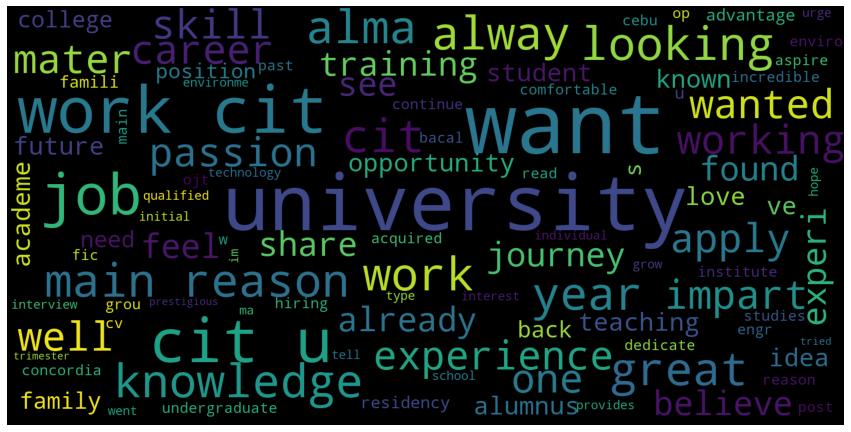

In [4]:
#Visualizing common words in the answers,
#size of each word represents its frequency of occurence in the data
def generate_wordcloud(data, title = None):
    wordcloud = WordCloud(
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=4).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(data_a["answers"])

In [5]:
#Tokenizing and converting the answers into numerical vectors or 
#convert text into sequences so the network or model can deal with it as input
max_fatures = 500
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['answers'].values)
X = tokenizer.texts_to_sequences(data['answers'].values)
X = pad_sequences(X)

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

64
42


In [6]:
#Graphing purpose, Visual representation of the learning
def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    #plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

<b>MODEL A

In [7]:
#Composing the LSTM network. Putting the Hyperparameters
#Using softmax as activation because Network used is 'Categorial Crossentropy'
class Model_A():
    def __new__(self):
        embed_dim = 120
        lstm_out = 176
        model = Sequential()
        model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
        model.add(SpatialDropout1D(0.4))
        model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
        model.add(Dense(2,activation='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
        return model

model_a = Model_A()

print(model_a.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 120)           60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 74, 120)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
#Here I declare splitting the data into training and test data set
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(37, 74) (37, 2)
(16, 74) (16, 2)


In [9]:
#Here we train the model using the batch size 5 for I only have few data with 5 epochs only
batch_size = 4
history = model_a.fit(X_train, Y_train, epochs =10, batch_size=batch_size, verbose = 2)

Epoch 1/10
10/10 - 2s - loss: 0.6882 - accuracy: 0.5946 - 2s/epoch - 221ms/step
Epoch 2/10
10/10 - 1s - loss: 0.6476 - accuracy: 0.7297 - 705ms/epoch - 70ms/step
Epoch 3/10
10/10 - 1s - loss: 0.6209 - accuracy: 0.6216 - 645ms/epoch - 64ms/step
Epoch 4/10
10/10 - 1s - loss: 0.5755 - accuracy: 0.7027 - 580ms/epoch - 58ms/step
Epoch 5/10
10/10 - 1s - loss: 0.6363 - accuracy: 0.7838 - 599ms/epoch - 60ms/step
Epoch 6/10
10/10 - 1s - loss: 0.4152 - accuracy: 0.9189 - 590ms/epoch - 59ms/step
Epoch 7/10
10/10 - 1s - loss: 0.4164 - accuracy: 1.0000 - 587ms/epoch - 59ms/step
Epoch 8/10
10/10 - 1s - loss: 0.3714 - accuracy: 0.9730 - 589ms/epoch - 59ms/step
Epoch 9/10
10/10 - 1s - loss: 0.2612 - accuracy: 1.0000 - 590ms/epoch - 59ms/step
Epoch 10/10
10/10 - 1s - loss: 0.1789 - accuracy: 0.9730 - 597ms/epoch - 60ms/step


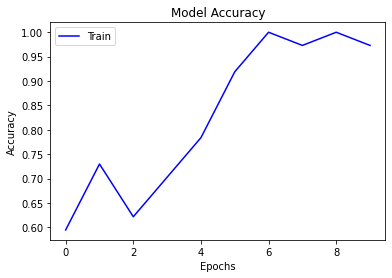

In [10]:
#visual representation of the model's accuracy after training
generate_graph(history)

In [11]:
class Model_B():
    def __new__(self):
        model = Sequential()
        model.add(Embedding(max_fatures,128 ,input_length = X.shape[1]))
        model.add(SpatialDropout1D(0.2))
        model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
        model.add(Dense(2,activation='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
        return model

model_b = Model_B()

print(model_b.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 74, 128)           64000     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 74, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 2)                 394       
                                                                 
Total params: 319,194
Trainable params: 319,194
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
batch_size = 4
history_b = model_b.fit(X_train, Y_train, epochs =10, batch_size=batch_size, verbose = 2)

Epoch 1/10
10/10 - 2s - loss: 0.6936 - accuracy: 0.5946 - 2s/epoch - 226ms/step
Epoch 2/10
10/10 - 1s - loss: 0.6553 - accuracy: 0.6757 - 791ms/epoch - 79ms/step
Epoch 3/10
10/10 - 1s - loss: 0.6723 - accuracy: 0.7027 - 776ms/epoch - 78ms/step
Epoch 4/10
10/10 - 1s - loss: 0.5335 - accuracy: 0.7297 - 759ms/epoch - 76ms/step
Epoch 5/10
10/10 - 1s - loss: 0.4095 - accuracy: 0.7568 - 770ms/epoch - 77ms/step
Epoch 6/10
10/10 - 1s - loss: 0.5095 - accuracy: 0.9189 - 777ms/epoch - 78ms/step
Epoch 7/10
10/10 - 1s - loss: 0.1813 - accuracy: 1.0000 - 771ms/epoch - 77ms/step
Epoch 8/10
10/10 - 1s - loss: 0.1074 - accuracy: 0.9730 - 768ms/epoch - 77ms/step
Epoch 9/10
10/10 - 1s - loss: 0.0504 - accuracy: 1.0000 - 760ms/epoch - 76ms/step
Epoch 10/10
10/10 - 1s - loss: 0.0297 - accuracy: 1.0000 - 760ms/epoch - 76ms/step


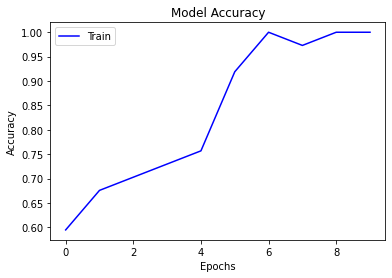

In [13]:
generate_graph(history_b)

In [14]:
class Model_C():
    def __new__(self):
        model = Sequential()
        model.add(Embedding(max_fatures,128 ,input_length = X.shape[1]))
        model.add(SpatialDropout1D(0.2))
        model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
        model.add(Dense(2,activation='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
        return model

model_c= Model_C()


In [15]:
print(model_c.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 74, 128)           64000     
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 74, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 113,538
Trainable params: 113,538
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
batch_size = 4
history_c = model_c.fit(X_train, Y_train, epochs =10, batch_size=batch_size, verbose = 2)

Epoch 1/10
10/10 - 2s - loss: 0.6933 - accuracy: 0.5135 - 2s/epoch - 214ms/step
Epoch 2/10
10/10 - 0s - loss: 0.6577 - accuracy: 0.7027 - 481ms/epoch - 48ms/step
Epoch 3/10
10/10 - 0s - loss: 0.6009 - accuracy: 0.7027 - 484ms/epoch - 48ms/step
Epoch 4/10
10/10 - 0s - loss: 0.5731 - accuracy: 0.8108 - 474ms/epoch - 47ms/step
Epoch 5/10
10/10 - 0s - loss: 0.3805 - accuracy: 0.8649 - 478ms/epoch - 48ms/step
Epoch 6/10
10/10 - 0s - loss: 0.2984 - accuracy: 0.8919 - 473ms/epoch - 47ms/step
Epoch 7/10
10/10 - 0s - loss: 0.2186 - accuracy: 1.0000 - 486ms/epoch - 49ms/step
Epoch 8/10
10/10 - 0s - loss: 0.1454 - accuracy: 0.9459 - 494ms/epoch - 49ms/step
Epoch 9/10
10/10 - 0s - loss: 0.0970 - accuracy: 0.9459 - 491ms/epoch - 49ms/step
Epoch 10/10
10/10 - 0s - loss: 0.0588 - accuracy: 1.0000 - 496ms/epoch - 50ms/step


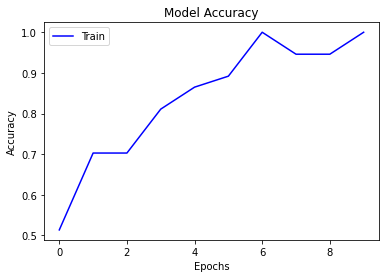

In [17]:
generate_graph(history_c)

In [18]:
#Extraction of validation set, measuring score and accuracy
validation_size = 11

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

def model_evaluate(model):

    score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 4)
    print("score: %.2f" % (score))
    print("acc: %.2f" % (acc))

In [25]:
print("MODEL A: ")
model_evaluate(model_a)
print("MODEL B: ")
model_evaluate(model_b)
print("MODEL C: ")
model_evaluate(model_c)

MODEL A: 
2/2 - 0s - loss: 0.5766 - accuracy: 0.8000 - 65ms/epoch - 33ms/step
score: 0.58
acc: 0.80
MODEL B: 
2/2 - 0s - loss: 1.1278 - accuracy: 0.8000 - 65ms/epoch - 33ms/step
score: 1.13
acc: 0.80
MODEL C: 
2/2 - 0s - loss: 1.2659 - accuracy: 0.6000 - 26ms/epoch - 13ms/step
score: 1.27
acc: 0.60


In [20]:
#In here I measured the number of correct guesses
#Based on the results we can clearly see the positive prediction is way more higher than the negative this maybe due to lack of data
def negNpos_predict(model):
    pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
    for x in range(len(X_validate)):
    
        result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
        if np.argmax(result) == np.argmax(Y_validate[x]):
            if np.argmax(Y_validate[x]) == 0:
                neg_correct += 1
            else:
                pos_correct += 1
       
        if np.argmax(Y_validate[x]) == 0:
            neg_cnt += 1
        else:
            pos_cnt += 1
    print("pos_acc", pos_correct/pos_cnt*100, "%")
    print("neg_acc", neg_correct/neg_cnt*100, "%")

In [26]:
print("MODEL A: ")
negNpos_predict(model_a)
print("MODEL B: ")
negNpos_predict(model_b)
print("MODEL C: ")
negNpos_predict(model_c)

MODEL A: 
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
pos_acc 62.5 %
neg_acc 66.66666666666666 %
MODEL B: 
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
pos_acc 75.0 %
neg_acc 66.66666666666666 %
MODEL C: 
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


In [30]:
answer = ["My 15 years residency with CIT-University is an advantage as I am familiar with the different departments and people or team working in CIT-University. With my experience and acquired knowledge, I believe that I can contribute that is necessary."]
#vectorizing answers by the pre-fitted tokenizer instance
sequenced = tokenizer.texts_to_sequences(answer)
#padding the answers to have exactly the same shape as `embedding_2` input
padded = pad_sequences(sequenced, maxlen=74, dtype='int32', value=0)
mod_a = model_a.predict(padded,batch_size=1,verbose = 2)[0]
mod_b = model_b.predict(padded,batch_size=1,verbose = 2)[0]
mod_c = model_c.predict(padded,batch_size=1,verbose = 2)[0]

def predicts(model):
    
    for i in model:
        if(i>=0.5):
            pred_labels = 1
        else:
            pred_labels = 0
    print("prediction: ",i)
    print("label: ",pred_labels)
    return pred_labels

def label(val):
    if val == 1:
        label = "Positive"
    elif val == 0:
        label = "Negative"
    return label
    
a = predicts(mod_a)
print(label(a))
b = predicts(mod_b)
print(label(b))
c = predicts(mod_c)
print(label(c))

def results(sentiment):
    eval = 0
    if (np.argmax(sentiment) == 1):
        eval = 1
    return eval
#Function of prediction

def predict(sentiment):
    evaluation = "NOT-HIRED"
    if (results(sentiment)== 1):
        evaluation = "HIRED"   
    return evaluation

print("MODEL A: "+predict(mod_a))
print("MODEL B: "+predict(mod_b))
print("MODEL C: "+predict(mod_c))







1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
prediction:  0.8392209
label:  1
Positive
prediction:  0.99354666
label:  1
Positive
prediction:  0.99831355
label:  1
Positive
MODEL A: HIRED
MODEL B: HIRED
MODEL C: HIRED


Text(0, 0.5, 'Percentage')

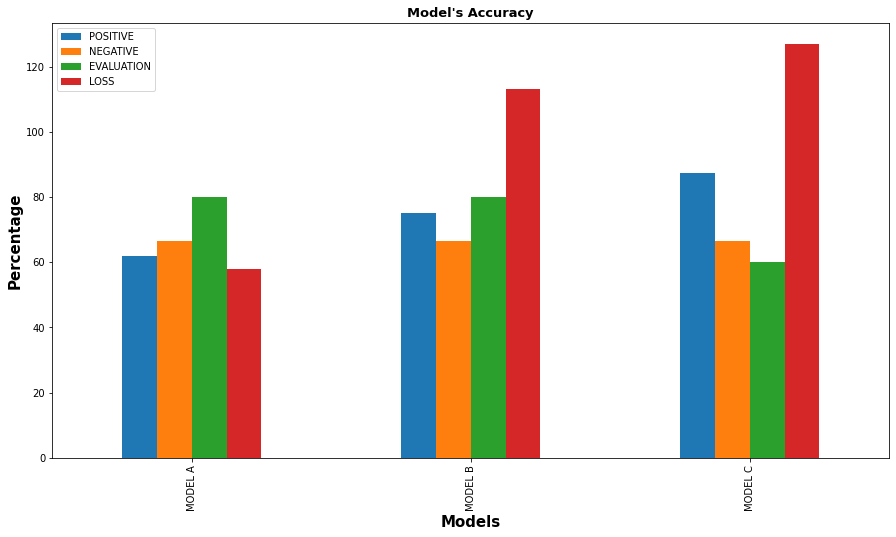

In [5]:
#Plot for visualization
plotdata = pd.DataFrame({

    "POSITIVE":[62,75,87.5],

    "NEGATIVE":[66.6,66.6,66.6],

    "EVALUATION":[80,80,60],

    "LOSS":[58,113,127]},

    index=["MODEL A", "MODEL B", "MODEL C"])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("Model's Accuracy", fontweight ='bold', fontsize = 13)

plt.xlabel("Models", fontweight ='bold', fontsize = 15)

plt.ylabel("Percentage", fontweight ='bold', fontsize = 15)

In [28]:
#Saving the best model for integration
model_a.save("A-model.h5")
model_b.save("B-model.h5")
model_c.save("C-model.h5")
